In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import warnings
warnings.filterwarnings('ignore')
import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer
import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle
from sklearn.metrics import roc_auc_score
from tqdm import tqdm
import os

In [3]:
train=pd.read_csv('/content/drive/MyDrive/Tweets Disaster /train.csv')
test=pd.read_csv('/content/drive/MyDrive/Tweets Disaster /test.csv')
print('Train shape:-',train.shape)
print('Test shape:-',test.shape)

Train shape:- (7613, 5)
Test shape:- (3263, 4)


In [4]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [5]:
test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [6]:
train.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [8]:
data_nan = (train.isnull().sum() / len(train)) * 100
data_nan = data_nan.drop(data_nan[data_nan == 0].index).sort_values(ascending=False)[:10]
missing_data = pd.DataFrame({'Missing Ratio' :data_nan})
missing_data.head(5)

,Missing Ratio
location,33.272035
keyword,0.801261


Text(0.5, 1.0, 'Percent missing data by feature')

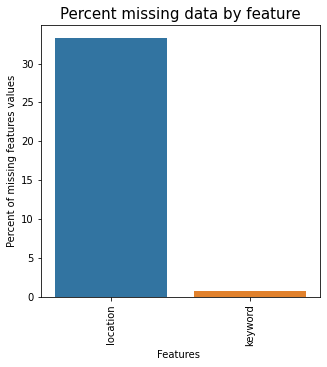

In [10]:
f, ax = plt.subplots(figsize=(5, 5))
plt.xticks(rotation='90')
sns.barplot(x=data_nan.index, y=data_nan)
plt.xlabel('Features ', fontsize=10)
plt.ylabel('Percent of missing features values', fontsize=10)
plt.title('Percent missing data by feature', fontsize=15)

In [11]:
print('NO. Unique Keyword : ',len(train.keyword.unique()))
train.keyword.value_counts(ascending=False)

NO. Unique Keyword :  222


fatalities               45
deluge                   42
armageddon               42
sinking                  41
damage                   41
                         ..
forest%20fire            19
epicentre                12
threat                   11
inundation               10
radiation%20emergency     9
Name: keyword, Length: 221, dtype: int64

In [12]:
print('NO. Unique Location : ',len(train.location.unique()))
train.location.value_counts(ascending=False)

NO. Unique Location :  3342


USA                    104
New York                71
United States           50
London                  45
Canada                  29
                      ... 
MontrÌ©al, QuÌ©bec       1
Montreal                 1
ÌÏT: 6.4682,3.18287      1
Live4Heed??              1
Lincoln                  1
Name: location, Length: 3341, dtype: int64

In [13]:
train.describe()

,id,target
count,7613.000000,7613.00000
mean,5441.934848,0.42966
std,3137.116090,0.49506
min,1.000000,0.00000
25%,2734.000000,0.00000
50%,5408.000000,0.00000
75%,8146.000000,1.00000
max,10873.000000,1.00000


In [13]:
test.isnull().sum()

id             0
keyword       26
location    1105
text           0
dtype: int64

In [14]:
def perc_on_bar(data,x):
    total_len = len(data[x]) # length of the column
    plt.figure(figsize=(5,5))
    ax = sns.countplot(data[x],palette='Paired')
    for p in ax.patches:
        per = '{:.1f}%'.format(100 * p.get_height()/total_len) 
        x = p.get_x() + p.get_width() / 2 - 0.10
        y = p.get_y() + p.get_height()          
        ax.annotate(per, (x, y), size = 12) # annotate the percantage 
    plt.show() # show the plot

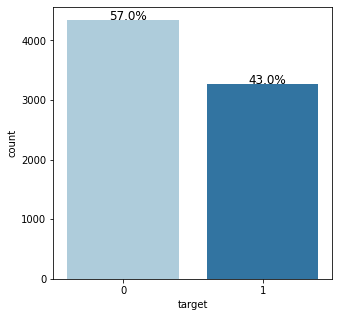

In [15]:
perc_on_bar(train,'target')

In [20]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [21]:
from tqdm import tqdm
import re

In [22]:
# Remove Emoji
def deEmojify(text):
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags = re.UNICODE)
    return regrex_pattern.sub(r'',text)
def decontractions(phrase):
    """decontracted takes text and convert contractions into natural form.
     ref: https://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python/47091490#47091490"""
    # specific
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    phrase = re.sub(r"won\’t", "will not", phrase)
    phrase = re.sub(r"can\’t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)

    phrase = re.sub(r"n\’t", " not", phrase)
    phrase = re.sub(r"\’re", " are", phrase)
    phrase = re.sub(r"\’s", " is", phrase)
    phrase = re.sub(r"\’d", " would", phrase)
    phrase = re.sub(r"\’ll", " will", phrase)
    phrase = re.sub(r"\’t", " not", phrase)
    phrase = re.sub(r"\’ve", " have", phrase)
    phrase = re.sub(r"\’m", " am", phrase)

    return phrase

def preprocess(text_col,stopword):
    preprocessed = []
    for sentence in tqdm(text_col.values):
        # Replace "carriage return" with "space".
        sentence=str(sentence)
        sent = sentence.replace('\\r', ' ')
        # Replace "quotes" with "space".
        sent = sent.replace('\\"', ' ')
        # Replace "line feed" with "space".
        sent = sent.replace('\\n', ' ')
        # Replace characters between words with "space".
        sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
        #remove stop words
        #decontraction
        sent=decontractions(sent)
        #Remove emoji
        sent=deEmojify(sent)
        if stopword:
            sent = ' '.join(e for e in sent.split() if e not in stopwords)
        else:
            sent = ' '.join(e for e in sent.split())
        # to lowercase
        preprocessed.append(sent.lower().strip())
    return preprocessed
train['text']=preprocess(train['text'],stopword=False)
test['text']=preprocess(test['text'],stopword=False)

100%|██████████| 3263/3263 [00:00<00:00, 23751.33it/s]


In [23]:
train['len_comm']=train['text'].apply(lambda x:len(x.split()))
test['len_comm']=test['text'].apply(lambda x:len(x.split()))

In [24]:
train['keyword']=train['keyword'].fillna('No keyword')
test['keyword']=test['keyword'].fillna('No keyword')

In [25]:
train['location']=train['location'].fillna('No location')
test['location']=test['location'].fillna('No location')

In [26]:
def plot_categories(data,feature,title1):
    plt.figure(figsize=(15,8))
    count=data[feature].value_counts()
    sns.barplot(x=count[:15].values, y=count[:15].index)
    plt.title('(a)'+title1,fontsize=15)
    plt.xlabel('Counts', fontsize=13)
    plt.show()

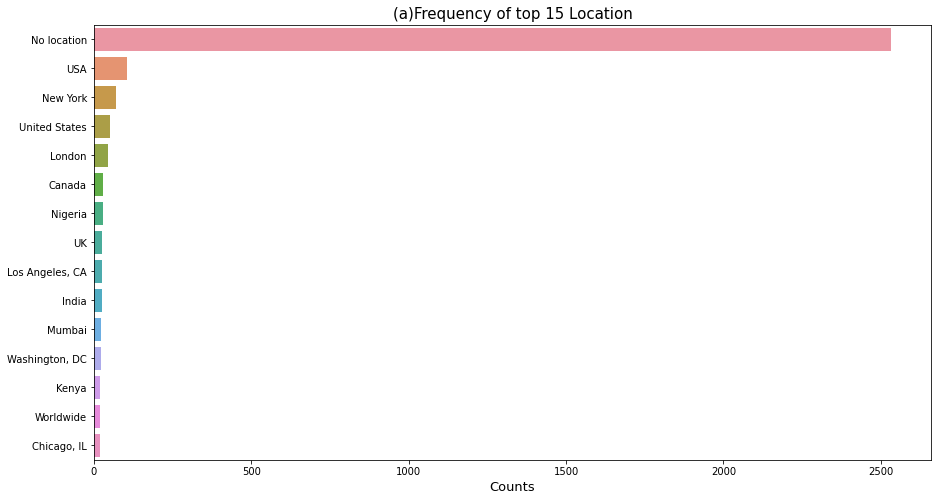

In [27]:
title1='Frequency of top 15 Location'
plot_categories(train,'location',title1)

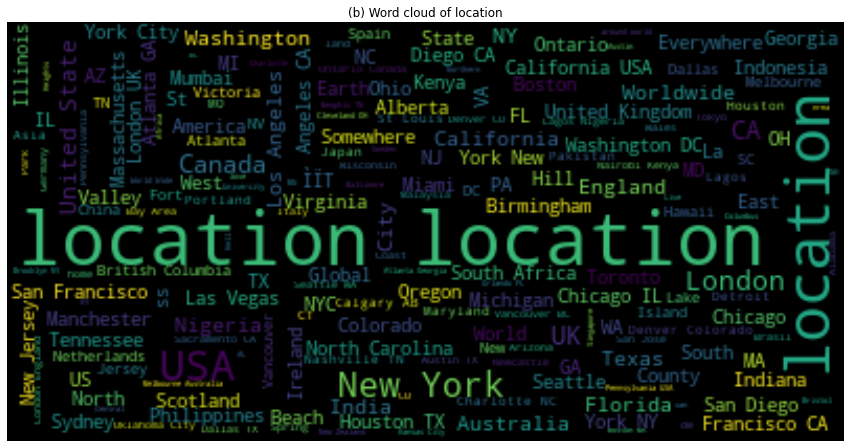

In [28]:
from wordcloud import WordCloud, STOPWORDS
plt.figure(figsize = (15, 15))
plt.title("(b) Word cloud of location")
wc = WordCloud().generate(" ".join(train['location'].astype(str)))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

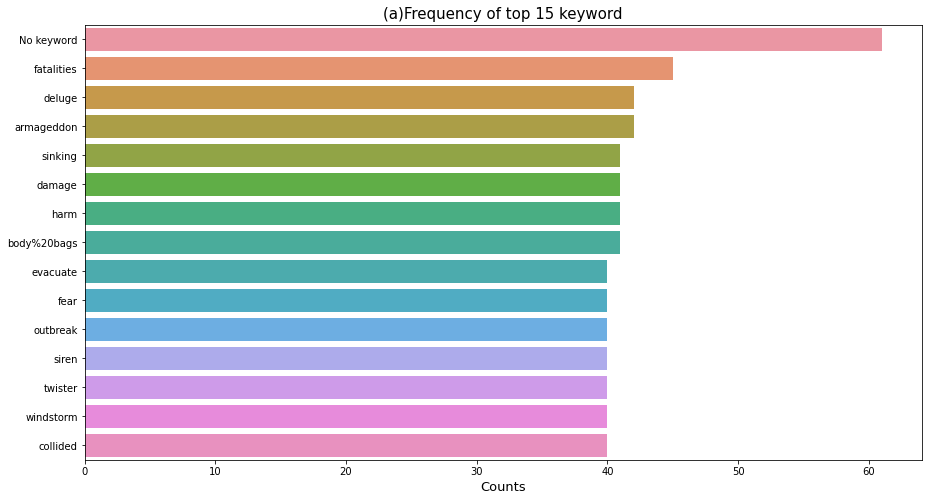

In [29]:
title1='Frequency of top 15 keyword'
plot_categories(train,'keyword',title1)

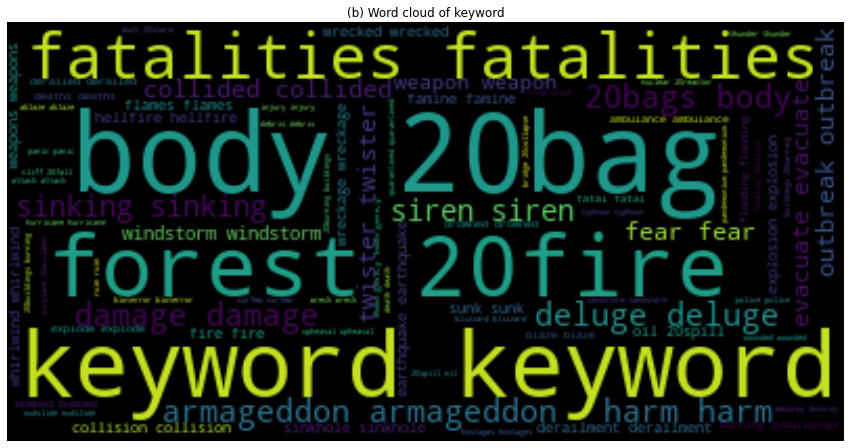

In [30]:
from wordcloud import WordCloud, STOPWORDS
plt.figure(figsize = (15, 15))
plt.title("(b) Word cloud of keyword")
wc = WordCloud().generate(" ".join(train['keyword'].astype(str)))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

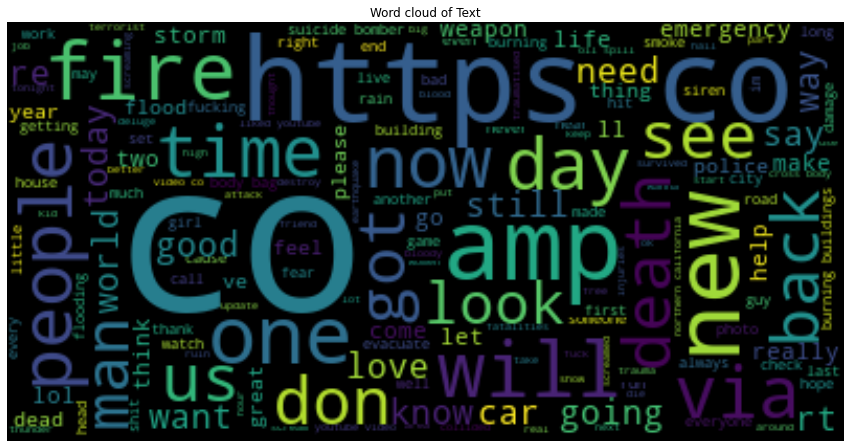

In [31]:
from wordcloud import WordCloud, STOPWORDS
plt.figure(figsize = (15, 15))
plt.title("Word cloud of Text")
wc = WordCloud().generate(" ".join(train['text'].astype(str)))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

In [32]:
def plot(data,x,target='target'):
    fig,axs = plt.subplots(2,2,figsize=(12,10))
    axs[0, 0].set_title('Distribution of Positive comment')
    sns.distplot(data[(data[target] == 1)][x],ax=axs[0,0],color='teal')
    axs[0, 1].set_title('Distribution of Negative comment')
    sns.distplot(data[(data[target] == 0)][x],ax=axs[0,1],color='orange')
    axs[1,0].set_title('Boxplot of ' + x + ' w.r.t label')
    sns.boxplot(data[target],data[x],ax=axs[1,0],palette='gist_rainbow')
    axs[1,1].set_title('Boxplot of ' + x + ' w.r.t label - Without outliers')
    sns.boxplot(data[target],data[x],ax=axs[1,1],showfliers=False,palette='gist_rainbow')
    plt.tight_layout()
    plt.show()

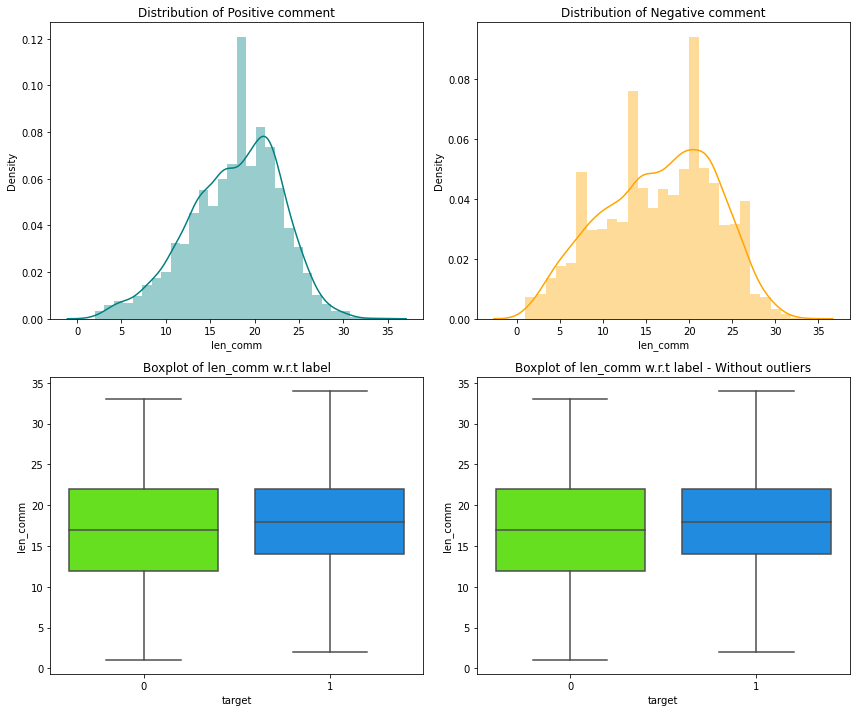

In [33]:
plot(train,'len_comm')

In [34]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [35]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
def generate_sentiment_scores(data):
    sid = SentimentIntensityAnalyzer()
    neg=[]
    pos=[]
    neu=[]
    comp=[]
    for sentence in tqdm(data['text'].values): 
        sentence_sentiment_score = sid.polarity_scores(sentence)
        comp.append(sentence_sentiment_score['compound'])
        neg.append(sentence_sentiment_score['neg'])
        pos.append(sentence_sentiment_score['pos'])
        neu.append(sentence_sentiment_score['neu'])
    return comp,neg,pos,neu

In [36]:
train['comp'],train['neg'],train['pos'],train['neu']=generate_sentiment_scores(train)
test['comp'],test['neg'],test['pos'],test['neu']=generate_sentiment_scores(test)

100%|██████████| 3263/3263 [00:00<00:00, 4223.07it/s]


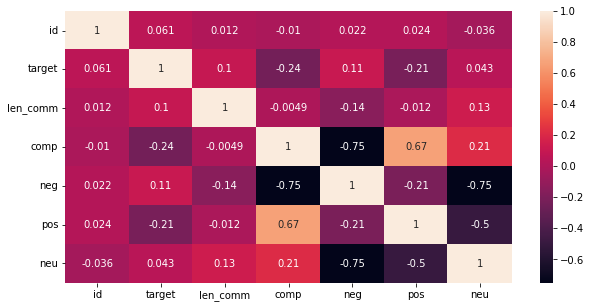

In [37]:
plt.figure(figsize=(10,5))
sns.heatmap(train.corr(),annot=True)

In [38]:
y=train['target']
X=train.drop(['target','id'],axis=1)

In [39]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=42,stratify=y)

In [40]:
%%time
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
vec = tfidf_desc = TfidfVectorizer(max_features=200000, ngram_range=(1, 3), stop_words='english')
X_train_comment = vec.fit_transform(X_train['text'])
X_test_comment = vec.transform(X_test['text'])
test_comment=vec.transform(test['text'])

CPU times: user 669 ms, sys: 5.89 ms, total: 675 ms
Wall time: 690 ms


In [41]:
%%time
from sklearn.preprocessing import LabelBinarizer
lb_brand_keyword = LabelBinarizer(sparse_output=True)
X_train_keyword = lb_brand_keyword.fit_transform(X_train['keyword'])
X_test_keyword = lb_brand_keyword.transform(X_test['keyword'])
test_keyword = lb_brand_keyword.transform(test['keyword'])

CPU times: user 75.1 ms, sys: 0 ns, total: 75.1 ms
Wall time: 75.4 ms


In [42]:
%%time
from sklearn.preprocessing import LabelBinarizer
lb_brand_location = LabelBinarizer(sparse_output=True)
X_train_location = lb_brand_location.fit_transform(X_train['location'])
X_test_location = lb_brand_location.transform(X_test['location'])
test_location = lb_brand_location.transform(test['location'])

CPU times: user 918 ms, sys: 77.9 ms, total: 996 ms
Wall time: 867 ms


In [43]:
%%time
from sklearn.preprocessing import Normalizer
trans = Normalizer()
X_train_comp=trans.fit_transform(X_train['comp'].values.reshape(-1,1))
X_test_comp=trans.transform(X_test['comp'].values.reshape(-1,1))
test_comp=trans.transform(test['comp'].values.reshape(-1,1))

CPU times: user 1.95 ms, sys: 0 ns, total: 1.95 ms
Wall time: 1.97 ms


In [44]:
%%time
from sklearn.preprocessing import Normalizer
trans = Normalizer()
X_train_neg=trans.fit_transform(X_train['neg'].values.reshape(-1,1))
X_test_neg=trans.transform(X_test['neg'].values.reshape(-1,1))
test_neg=trans.transform(test['neg'].values.reshape(-1,1))

CPU times: user 1.56 ms, sys: 0 ns, total: 1.56 ms
Wall time: 1.57 ms


In [45]:
%%time
from sklearn.preprocessing import Normalizer
trans = Normalizer()
X_train_pos=trans.fit_transform(X_train['pos'].values.reshape(-1,1))
X_test_pos=trans.transform(X_test['pos'].values.reshape(-1,1))
test_pos=trans.transform(test['pos'].values.reshape(-1,1))

CPU times: user 2.41 ms, sys: 0 ns, total: 2.41 ms
Wall time: 2.62 ms


In [46]:
%%time
from sklearn.preprocessing import Normalizer
trans = Normalizer()
X_train_neu=trans.fit_transform(X_train['neu'].values.reshape(-1,1))
X_test_neu=trans.transform(X_test['neu'].values.reshape(-1,1))
test_neu=trans.transform(test['neu'].values.reshape(-1,1))

CPU times: user 2.83 ms, sys: 0 ns, total: 2.83 ms
Wall time: 3.59 ms


In [47]:
%%time
from sklearn.preprocessing import Normalizer
trans = Normalizer()
X_train_len=trans.fit_transform(X_train['len_comm'].values.reshape(-1,1))
X_test_len=trans.transform(X_test['len_comm'].values.reshape(-1,1))
test_len=trans.transform(test['len_comm'].values.reshape(-1,1))

CPU times: user 3.25 ms, sys: 11 µs, total: 3.26 ms
Wall time: 6.47 ms


In [48]:
%%time
from scipy.sparse import hstack
train_s=hstack((X_train_comment,X_train_keyword,X_train_location,X_train_comp,X_train_neg,X_train_pos,X_train_neu,X_train_len)).tocsr().astype('float32')
test_s=hstack((X_test_comment,X_test_keyword,X_test_location,X_test_comp,X_test_neg,X_test_pos,X_test_neu,X_test_len)).tocsr().astype('float32')
test_final=hstack((test_comment,test_keyword,test_location,test_comp,test_neg,test_pos,test_neu,test_len)).tocsr().astype('float32')

CPU times: user 25.6 ms, sys: 0 ns, total: 25.6 ms
Wall time: 26.1 ms


In [49]:
print(train_s.shape,y_train.shape)
print(test_s.shape,y_test.shape)
print(test_final.shape)

(5329, 94097) (5329,)
(2284, 94097) (2284,)
(3263, 94097)


In [50]:
def get_metrics_score(model,train,test,train_y,test_y,flag=True):
    '''
    model : classifier to predict values of X

    '''
    # defining an empty list to store train and test results
    score_list=[] 
    
    pred_train = model.predict(train)
    pred_test = model.predict(test)
    
    train_acc = model.score(train,train_y)
    test_acc = model.score(test,test_y)
    
    train_recall = metrics.recall_score(train_y,pred_train)
    test_recall = metrics.recall_score(test_y,pred_test)
    
    train_precision = metrics.precision_score(train_y,pred_train)
    test_precision = metrics.precision_score(test_y,pred_test)
    
    score_list.extend((train_acc,test_acc,train_recall,test_recall,train_precision,test_precision))
        
    # If the flag is set to True then only the following print statements will be dispayed. The default value is set to True.
    if flag == True: 
        print("Accuracy on training set : ",model.score(train,train_y))
        print("Accuracy on test set : ",model.score(test,test_y))
        print("Recall on training set : ",metrics.recall_score(train_y,pred_train))
        print("Recall on test set : ",metrics.recall_score(test_y,pred_test))
        print("Precision on training set : ",metrics.precision_score(train_y,pred_train))
        print("Precision on test set : ",metrics.precision_score(test_y,pred_test))
        print("log_loss on training set : ",metrics.log_loss(train_y,pred_train))
        print("log_loss on test set : ",metrics.log_loss(test_y,pred_test))
    return score_list # returning the list with train and test scores

In [51]:
def make_confusion_matrix(model,y_actual,labels=[1, 0]):
    '''
    model : classifier to predict values of X
    y_actual : ground truth  
    
    '''
    y_predict = model.predict(test_s)
    cm=metrics.confusion_matrix( y_actual, y_predict, labels=[0, 1])
    df_cm = pd.DataFrame(cm, index = [i for i in ["Actual - No","Actual - Yes"]],
                  columns = [i for i in ['Predicted - No','Predicted - Yes']])
    group_counts = ["{0:0.0f}".format(value) for value in
                cm.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in
                         cm.flatten()/np.sum(cm)]
    labels = [f"{v1}\n{v2}" for v1, v2 in
              zip(group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    plt.figure(figsize = (10,7))
    sns.heatmap(df_cm, annot=labels,fmt='')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [52]:
from sklearn.pipeline import Pipeline, make_pipeline
from tqdm import tqdm
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
#libraries to help with model building
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    AdaBoostClassifier,
    GradientBoostingClassifier,
    RandomForestClassifier,
    BaggingClassifier)
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import RidgeClassifier,LassoCV,RidgeClassifierCV
from sklearn.metrics import mean_squared_error, make_scorer,mean_squared_log_error
models = []  # Empty list to store all the models

# Appending pipelines for each model into the list

models.append(
    (
        "logistic",
        Pipeline(
            steps=[
                ("logistic", LogisticRegression(random_state=1,n_jobs=-1)),
            ]
        ),
    )
)


models.append(
    (
        "lgbm",
        Pipeline(
            steps=[
                ("LGBM", LGBMClassifier(random_state=1)),
            ]
        ),
    )
)


models.append(
    (
        "SGD",
        Pipeline(
            steps=[
                ("SGD", SGDClassifier(random_state=1)),
            ]
        ),
    )
)

models.append(
    (
        "DTREE",
        Pipeline(
            steps=[
                
                ("decision_tree", DecisionTreeClassifier(random_state=1,)),
            ]
        ),
    )
)


models.append(
    (
        "Bagging",
        Pipeline(
            steps=[
                
                ("random_forest", BaggingClassifier(random_state=1)),
            ]
        ),
    )
)


models.append(
    (
        "RF",
        Pipeline(
            steps=[
              
                ("random_forest", RandomForestClassifier(random_state=1)),
            ]
        ),
    )
)

models.append(
    (
        "ADB",
        Pipeline(
            steps=[
                
                ("adaboost", AdaBoostClassifier(random_state=1)),
            ]
        ),
    )
)


models.append(
    (
        "GBM",
        Pipeline(
            steps=[
                
                ("gradient_boosting", GradientBoostingClassifier(random_state=1)),
            ]
        ),
    )
)


models.append(
    (
        "XGB",
        Pipeline(
            steps=[
                ("xgboost", XGBClassifier(random_state=1,eval_metric='logloss')),
            ]
        ),
    )
)


results = []  # Empty list to store all model's CV scores
names = []  # Empty list to store name of the models

# loop through all models to get the mean cross validated score
from tqdm import tqdm
for name, model in tqdm(models):
    # Setting number of splits equal to 5
    scores = cross_val_score(model,train_s,y_train, cv=5,
                             scoring='accuracy')
    results.append(scores)
    names.append(name)
    print("{}: {}".format(name, scores.mean() * 100))

 11%|█         | 1/9 [00:09<01:18,  9.83s/it]

logistic: 75.77394322155573


 22%|██▏       | 2/9 [00:13<00:41,  5.98s/it]

lgbm: 76.26160716645087


 33%|███▎      | 3/9 [00:13<00:20,  3.42s/it]

SGD: 76.16788661927791


 44%|████▍     | 4/9 [00:31<00:45,  9.18s/it]

DTREE: 71.2701248139242


 56%|█████▌    | 5/9 [02:40<03:30, 52.53s/it]

Bagging: 73.6344722493812


 67%|██████▋   | 6/9 [05:02<04:08, 82.86s/it]

RF: 75.62365562983906


 78%|███████▊  | 7/9 [06:40<02:55, 87.78s/it]

ADB: 72.8651357802852


 89%|████████▉ | 8/9 [10:21<02:10, 130.13s/it]

GBM: 73.76589241515383


100%|██████████| 9/9 [11:07<00:00, 74.16s/it] 

XGB: 72.26458437932159


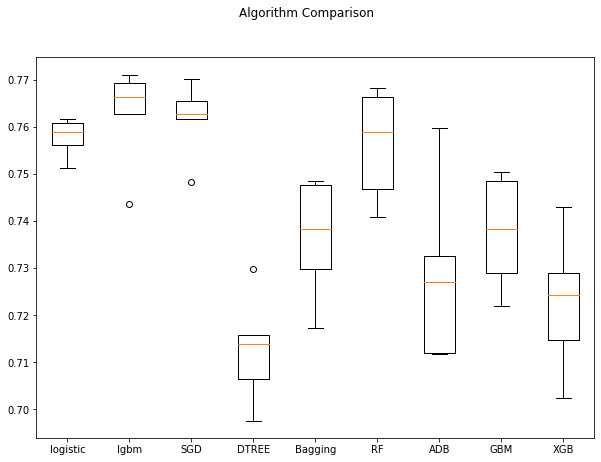

In [53]:
# Plotting boxplots for CV scores of all models defined above
fig = plt.figure(figsize=(10, 7))

fig.suptitle("Algorithm Comparison")
ax = fig.add_subplot(111)

plt.boxplot(results)
ax.set_xticklabels(names)

plt.show()

In [54]:
%%time
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
  
c_space = np.logspace(-5, 8, 15)
param_grid = {'C': c_space}
  
logreg = LogisticRegression()
  
logreg_cv = RandomizedSearchCV(logreg, param_grid, cv = 5)
  
logreg_cv.fit(train_s, y_train)
  
# Print the tuned parameters and score
print("Tuned Logistic Regression Parameters: {}".format(logreg_cv.best_params_)) 
print("Best score is {}".format(logreg_cv.best_score_))

Tuned Logistic Regression Parameters: {'C': 31.622776601683793}
Best score is 0.761303807837645
CPU times: user 1min 37s, sys: 1min 46s, total: 3min 23s
Wall time: 2min 10s


In [55]:
model= LogisticRegression(C=2275.845926074791)
model.fit(train_s,y_train)

LogisticRegression(C=2275.845926074791)

Accuracy on training set :  0.9983111277913305
Accuracy on test set :  0.7788966725043783
Recall on training set :  0.9978165938864629
Recall on test set :  0.7573904179408767
Precision on training set :  0.9982525120139799
Precision on test set :  0.7356435643564356
log_loss on training set :  0.05833217976054086
log_loss on test set :  7.63673186162161


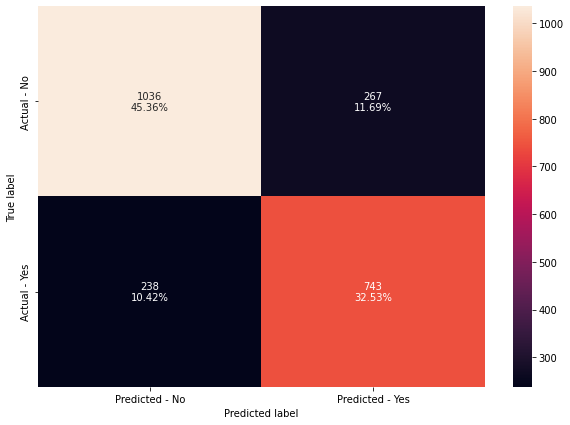

In [56]:
get_metrics_score(model,train_s,test_s,y_train,y_test)

# Creating confusion matrix
make_confusion_matrix(model, y_test)

In [58]:
%%time
from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMClassifier
params={'n_estimators':[100,500,1000],'learning_rate':[0.05,0.15,0.25]}
model_lgbm= LGBMClassifier(colsample_bytree=0.8,
               min_child_samples=50)

model=GridSearchCV(estimator = model_lgbm, param_grid = params,
                                    return_train_score=True, scoring = 'accuracy',
                                    cv = 3,verbose=2,n_jobs=-1)
model.fit(train_s,y_train)
print("Tuned Lightgbm Classifier Parameters: {}".format(model.best_params_)) 
print("Best score is {}".format(model.best_score_))

Fitting 3 folds for each of 9 candidates, totalling 27 fits
Tuned Lightgbm Classifier Parameters: {'learning_rate': 0.05, 'n_estimators': 100}
Best score is 0.685117728871246
CPU times: user 836 ms, sys: 111 ms, total: 947 ms
Wall time: 31.9 s


In [59]:
%%time
lgbm_model = LGBMClassifier(n_estimators=100, learning_rate=0.05,max_depth=5,
               num_leaves=31,subsample=0.9,colsample_bytree=0.8,
               min_child_samples=50, n_jobs=-1)

lgbm_model.fit(train_s, y_train)


CPU times: user 314 ms, sys: 5.49 ms, total: 319 ms
Wall time: 321 ms


Accuracy on training set :  0.7226496528429349
Accuracy on test set :  0.7132224168126094
Recall on training set :  0.5899563318777292
Recall on test set :  0.46992864424057085
Precision on training set :  0.7148148148148148
Precision on test set :  0.7734899328859061
log_loss on training set :  9.579422498534973
log_loss on test set :  9.904994082451651


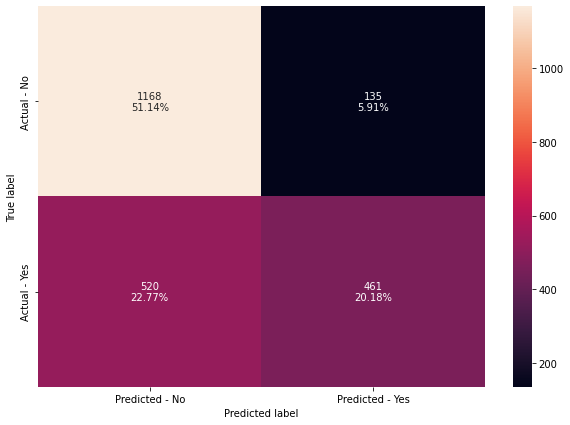

In [60]:
get_metrics_score(lgbm_model,train_s,test_s,y_train,y_test)

# Creating confusion matrix
make_confusion_matrix(lgbm_model, y_test)

In [61]:
%%time
from sklearn.linear_model import SGDClassifier
parameters = {'alpha':[10**x for x in range(-5, 5)],
              }
model_lr_reg = SGDClassifier(loss = "squared_loss",fit_intercept=False,l1_ratio=0.6)
model=GridSearchCV(estimator = model_lr_reg, param_grid = parameters,
                                    return_train_score=True, scoring = 'accuracy',\
                                    cv = 5,verbose=2,n_jobs=-1)
model.fit(train_s,y_train)
print("Tuned SGD Classifier Parameters: {}".format(model.best_params_)) 
print("Best score is {}".format(model.best_score_))

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Tuned SGD Classifier Parameters: {'alpha': 0.1}
Best score is 0.608557461089237
CPU times: user 548 ms, sys: 88.2 ms, total: 636 ms
Wall time: 18.1 s


In [62]:
model=SGDClassifier(alpha=0.1)
model.fit(train_s,y_train)

SGDClassifier(alpha=0.1)

Accuracy on training set :  0.570275849127416
Accuracy on test set :  0.5704903677758318
Recall on training set :  0.0
Recall on test set :  0.0
Precision on training set :  0.0
Precision on test set :  0.0
log_loss on training set :  14.842146358481038
log_loss on test set :  14.834737146850866


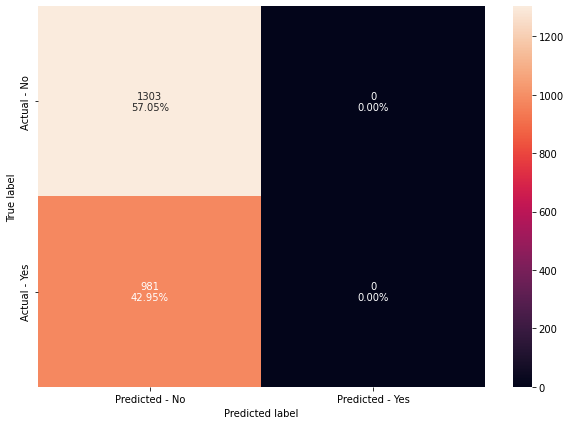

In [63]:
get_metrics_score(model,train_s,test_s,y_train,y_test)

# Creating confusion matrix
make_confusion_matrix(model, y_test)

## Best Model is Logistic Regression

In [64]:
model= LogisticRegression(C=2275.845926074791)
model.fit(train_s,y_train)

LogisticRegression(C=2275.845926074791)

In [65]:
y_pred=model.predict(test_final)

In [66]:
submission=pd.read_csv('/content/drive/MyDrive/Tweets Disaster /sample_submission.csv')
submission.head()

,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0


In [67]:
submission['target']=y_pred
submission.to_csv('final_submissionn_1.csv',index=False)